# Hadamard–Test Realization of NDWT Energies (Haar, $N=128$, $L=3$)

This section explains the quantum Hadamard–test part of the notebook.  
**Note:** The Hadamard test returns **energies** $|c_k|^2$, not coefficients $c_k$.

---

## Classical NDWT (Haar, MODWT-style)

We compute the nondecimated Haar wavelet transform of the Doppler128 signal:

- $w_1$ = finest detail level  
- $w_2$  
- $w_3$ = coarsest detail level  
- $a_3$ = approximation coefficients  

The stacked matrix  
$[w1; w2; w3; a3]$
is plotted with $\tt{plt.imshow(np.abs(Wstack), ...)}$, so it visualizes **magnitudes** of NDWT coefficients.

---

## Haar Coefficients and the Hadamard Test

We build the full $128\times128$ Haar transform matrix $W$ and obtain the classical decimated coefficient vector
$$
\tt{coeff\_dec = W @ y\_norm}
$$

For an index $k$ (here $k=70$), the Haar coefficient is $c_k$ and its **energy** is

$$
|c_k|^2.
$$

The Hadamard test does **not** measure $c_k$.  
Instead it evaluates the expectation value of the reflection operator

$$
U_k = W^\top (I - 2|k\rangle\langle k|)\,W.
$$

For a normalized input state $|x\rangle = y / \|y\|$,

$$
\langle x | U_k | x \rangle = 1 - 2|c_k|^2.
$$

Hence,

$$
 |c_k|^2 = \frac{1 - \langle x|U_k|x\rangle}{2}.
$$

The Hadamard circuit prepares the ancilla in superposition, applies the controlled-$U_k$, and measures $Z$ on the ancilla.  
The measured value gives the estimate
$$
\tt{prob\_est = (1 - expect\_Z)/2}
$$

which equals $|c_k|^2$.

---

## Plots: Energies, Not Coefficients

Two plots are produced at the end of the notebook:

### (A) Haar coefficients (real part)

This plot shows the **actual signed Haar coefficients**:
$$
\tt{axes[0].bar(indices, coeff\_dec.real)}
$$

The selected index $k$ is highlighted.

### (B) Classical vs Hadamard-test energies

This figure compares the **classical** and **quantum-estimated** energies:

- Classical: $|c_k|^2$  
- Quantum (Hadamard): $(1 - \langle x|U_k|x\rangle)/2$
$$
{\tt axes[1].bar([0,1], [prob\_class, prob\_est])}
$$

**Important:**  
This second plot shows **energies only**.  
Even though plot (A) displays coefficients, the Hadamard test yields only the magnitude-squared values.

---

## Summary

- The Hadamard test cannot retrieve the coefficient $c_k$ itself.  
- It retrieves only the **energy** $|c_k|^2$.  
- The reflection operator $U_k$ isolates a single Haar basis direction.  
- Classical and quantum estimates of $|c_k|^2$ match closely in the example.

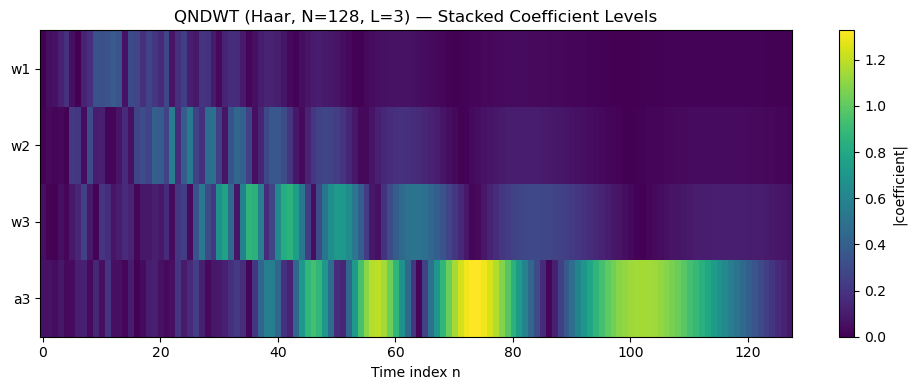

Elapsed time: 0.4840984344482422 seconds


In [9]:
# ============================================================
# QNDWT + Hadamard Test Example (N = 128, L = 3, Haar, Doppler)
# Now with plots for the quantum Hadamard-test realization
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.circuit.library import UnitaryGate

# -------------------------
# 1) Doppler signal (N=128)
# -------------------------
tic = time.time()
N = 128
t = np.linspace(0, 1, N)
Doppler128 = np.sqrt(t * (1 - t)) * np.sin((2 * np.pi * 1.05) / (t + 0.05))
y = Doppler128.copy()

# -------------------------
# 2) Haar filters and circular NDWT (L=3)
# -------------------------
h = np.array([1.0, 1.0]) / sqrt(2.0)
g = np.array([-1.0, 1.0]) / sqrt(2.0)

def circ_conv(x, f):
    n = x.size
    m = f.size
    out = np.zeros(n)
    for k in range(n):
        s = 0.0
        for t_ in range(m):
            s += x[(k - t_) % n] * f[t_]
        out[k] = s
    return out

def upsample_filter(base, j):
    if j == 1:
        return base.copy()
    z = np.zeros((base.size - 1) * (2**(j-1)) + 1)
    z[::2**(j-1)] = base
    return z

# Level 1
v0 = y.copy()
w1 = circ_conv(v0, upsample_filter(g, 1))
v1 = circ_conv(v0, upsample_filter(h, 1))

# Level 2
w2 = circ_conv(v1, upsample_filter(g, 2))
v2 = circ_conv(v1, upsample_filter(h, 2))

# Level 3
w3 = circ_conv(v2, upsample_filter(g, 3))
a3 = circ_conv(v2, upsample_filter(h, 3))

#Wstack = np.vstack([w1, w2, w3, a3])
Wstack = np.vstack([a3, w3, w2, w1]) #w1, w2, w3, a3])
# -------------------------
# 3) Plot stacked QNDWT
# -------------------------
plt.figure(figsize=(10, 4))
plt.imshow(np.abs(Wstack), aspect='auto', origin='lower')
plt.colorbar(label='|coefficient|')
plt.yticks(range(4), ['a3','w3','w2','w1']) #'w1', 'w2', 'w3', 'a3'])
plt.xlabel("Time index n")
plt.title("QNDWT (Haar, N=128, L=3) — Stacked Coefficient Levels")
plt.tight_layout()

plt.savefig("qndwt004a.png", dpi=300, bbox_inches="tight")
plt.savefig("qndwt004a.pdf", bbox_inches="tight")
plt.show()


toc = time.time()
print("Elapsed time:", toc - tic, "seconds")

In [10]:
# ============================================================
# B) HADAMARD TEST FOR ONE HAAR COEFFICIENT c_k
# ============================================================
tic = time.time()
# -------------------------
# 4) Build Haar DWT matrix W (128 × 128)
# -------------------------
def haar_level_mats(n):
    half = n // 2
    A = np.zeros((half, n))
    D = np.zeros((half, n))
    inv = 1.0 / sqrt(2.0)
    for k in range(half):
        A[k, 2*k]   = inv
        A[k, 2*k+1] = inv
        D[k, 2*k]   = inv
        D[k, 2*k+1] = -inv
    return A, D

def haar_multilevel(x, L):
    a = x.copy()
    n = len(x)
    details = {}
    for j in range(1, L+1):
        A, D = haar_level_mats(n)
        a_new = A @ a[:n]
        d_new = D @ a[:n]
        details[j] = d_new
        a[:n//2] = a_new
        n //= 2
    return a[:n], details

def dwt_matrix_haar(N, levels):
    W = np.zeros((N, N))
    I = np.eye(N)
    for i in range(N):
        a_top, det = haar_multilevel(I[:, i], levels)
        coeffs = [a_top] + [det[j] for j in range(levels, 0, -1)]
        W[:, i] = np.concatenate(coeffs)
    return W

levels = 7  # full orthogonal depth for N=128
W = dwt_matrix_haar(N, levels)

# -------------------------
# 5) Normalize signal and compute decimated Haar coefficients
# -------------------------
y_norm = y / np.linalg.norm(y)
coeff_dec = W @ y_norm

# pick coefficient index k to test
k = 70
prob_class = float(abs(coeff_dec[k])**2)

# -------------------------
# 6) Build reflection operator U = W^T (I - 2|k><k|) W
# -------------------------
D = np.eye(N)
D[k, k] = -1.0
U = W.T @ D @ W

exp_classical = float(y_norm @ (U @ y_norm))
prob_from_exp = (1.0 - exp_classical) / 2.0

print("\nClassical consistency check:")
print("  Classical |c_k|^2 =", prob_class)
print("  From ⟨x|U|x⟩      =", prob_from_exp)

U_gate = UnitaryGate(Operator(U), label=f"U_ref_k={k}")

# -------------------------
# 7) Qiskit Hadamard Test (8 qubits total)
# -------------------------
anc = QuantumRegister(1, "anc")
data = QuantumRegister(7, "data")
qc = QuantumCircuit(anc, data, name="HadamardTest_N128")

qc.initialize(y_norm.astype(complex), data)
qc.h(anc[0])
qc.append(U_gate.control(1), [anc[0]] + list(data))
qc.h(anc[0])

print("\nHadamard-test circuit:")
print(qc.draw(fold=-1))

sv = Statevector.from_instruction(qc)

# ancilla is rightmost qubit in Pauli string ordering
Zanc = SparsePauliOp.from_list([("I"*7 + "Z", 1.0)])
expect_Z = float(np.real(sv.expectation_value(Zanc)))
prob_est = (1.0 - expect_Z) / 2.0

print("\nHadamard Test Result:")
print("  |c_k|^2 (Hadamard) =", prob_est)
print("  Classical |c_k|^2  =", prob_class)
print("  Abs error          =", abs(prob_est - prob_class))

toc = time.time()
print("Elapsed time:", toc - tic, "seconds")


Classical consistency check:
  Classical |c_k|^2 = 0.010527865469730249
  From ⟨x|U|x⟩      = 0.010527865469730668

Hadamard-test circuit:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ┌───┐                                                                                                                                                                                                                                                                                    

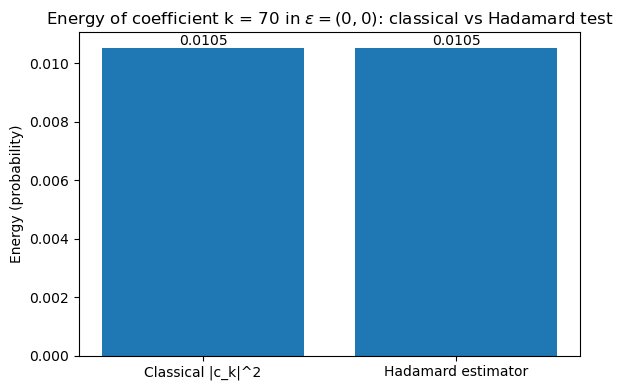

In [15]:
# ----------------------------------------------
# Plot: Classical vs Hadamard |c_k|^2 (bar plot)
# ----------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.bar([0, 1], [prob_class, prob_est])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Classical |c_k|^2", "Hadamard estimator"])
ax.set_ylabel("Energy (probability)")
ax.set_title(f"Energy of coefficient k = 70 in $\epsilon=(0,0)$: classical vs Hadamard test")

# Optionally annotate the bars
ax.text(0, prob_class, f"{prob_class:.4f}", ha="center", va="bottom")
ax.text(1, prob_est,   f"{prob_est:.4f}",   ha="center", va="bottom")

plt.tight_layout()
plt.savefig("qndwt004b.png", dpi=300, bbox_inches="tight")
plt.savefig("qndwt004b.pdf", bbox_inches="tight")
plt.show()
